<a href="https://colab.research.google.com/github/cmd-gunma-univ/DX-highschool/blob/main/Crow_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

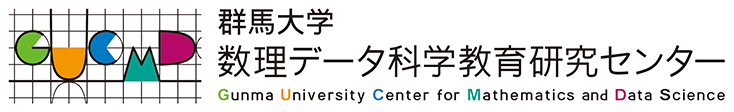

本デジタル教材の著作権は群馬大学数理データ科学教育研究センターに帰属します。

群馬大学出版会

Gunma University Press

TEL: 027-220-7180

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("NNXHzLZpvOI", width=800, height=450)

# YOLOを使った固有物体の画像検出（「カラス」を例として）

---
## 「カラス」のデータベース作成
* まずはOpen Imagesなどに既に完成されたモデルがないかを探す
* モデルがない場合はネットからデータを集めて自分でモデルを作る
* ネットにデータがない場合はデータを自分で作る

## Open Imagesから探す
https://storage.googleapis.com/openimages/web/index.html  
Googleが公開している、世界最大級のオープンな画像データセット  

以下のリストから欲しいクラスがあるかどうかを確認  
Exploreから検索

Open Imagesには"crow"は存在しないことが分かった。

# 自分でデータベースを作る(ハシブトガラス)
以下で作るデータベースは[こちら](https://drive.google.com/file/d/1Nh39iaCxTiyX1aaAQV4q1pnhU-VLolgS/view?usp=sharing)からダウンロードできます。

今回はiNaturalist(世界最大級の市民科学型・生物多様性データベース)を使用

* https://www.inaturalist.org/ で"Corvus macrorhynchos"(ハシブトガラス)を検索
* https://www.inaturalist.org/taxa/355745-Corvus-macrorhynchos-japonensis がデータ

以下でハシブトガラスの写真をダウンロード

In [ ]:
import requests
import os

os.makedirs("japonensis_images", exist_ok=True)

url = "https://api.inaturalist.org/v1/observations"
params = {
    "taxon_id": 355745, #ハシブトガラス（日本亜種）
    "quality_grade": "research", #研究品質の観察のみ取得
    "photos": True,
    "per_page": 200 #1リクエストあたりの最大件数(200が最大)
}

data = requests.get(url, params=params).json()

for obs in data["results"]:
    for photo in obs["photos"]:
        img_url = photo["url"].replace("square", "original")
        img_name = photo["id"]
        img = requests.get(img_url).content
        with open(f"japonensis_images/{img_name}.jpg", "wb") as f:
            f.write(img)

---
## Bounding boxの付与
https://www.makesense.ai/

In [ ]:
# 1つのファイルにまとめてダウンロード
! zip -r japonensis_images.zip japonensis_images

updating: japonensis_images/ (stored 0%)
updating: japonensis_images/609663480.jpg (deflated 0%)
updating: japonensis_images/601700392.jpg (deflated 1%)
updating: japonensis_images/603870692.jpg (deflated 0%)
updating: japonensis_images/609200138.jpg (deflated 0%)
updating: japonensis_images/604241554.jpg (deflated 0%)
updating: japonensis_images/594302766.jpg (deflated 0%)
updating: japonensis_images/598967511.jpg (deflated 0%)
updating: japonensis_images/588708934.jpg (deflated 0%)
updating: japonensis_images/607431689.jpg (deflated 0%)
updating: japonensis_images/602976416.jpg (deflated 0%)
updating: japonensis_images/590290831.jpg (deflated 0%)
updating: japonensis_images/596443091.jpg (deflated 0%)
updating: japonensis_images/577042082.jpg (deflated 0%)
updating: japonensis_images/580818234.jpg (deflated 0%)
updating: japonensis_images/591871343.jpg (deflated 0%)
updating: japonensis_images/588979604.jpg (deflated 0%)
updating: japonensis_images/584250169.jpg (deflated 0%)
updatin

Make Senseを使ってBounding Boxをつけ終わった。  
japonesis_images/にBounding Boxの.txtを入れる  
フォルダを作る

In [ ]:
!mkdir -p crow_dataset/images/train
!mkdir -p crow_dataset/images/val
!mkdir -p crow_dataset/labels/train
!mkdir -p crow_dataset/labels/val

画像とtxtを分離して"train"に移す

In [ ]:
! mv japonensis_images/*.jpg crow_dataset/images/train/
! mv japonensis_images/*.txt crow_dataset/labels/train/

trainにある画像とtxtの20%を"valに移す"

In [ ]:
import os, random, shutil
from pathlib import Path

train_img_dir = Path("crow_dataset/images/train")
train_lbl_dir = Path("crow_dataset/labels/train")
val_img_dir   = Path("crow_dataset/images/val")
val_lbl_dir   = Path("crow_dataset/labels/val")

val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

imgs = sorted([p for p in train_img_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
random.seed(42)

val_ratio = 0.2
n_val = max(1, int(len(imgs) * val_ratio))
val_imgs = random.sample(imgs, n_val)

moved = 0
skipped = 0

for img_path in val_imgs:
    lbl_path = train_lbl_dir / (img_path.stem + ".txt")

    # ラベルが無い画像はスキップ（YOLO形式として不整合なので）
    if not lbl_path.exists():
        skipped += 1
        continue

    shutil.move(str(img_path), str(val_img_dir / img_path.name))
    shutil.move(str(lbl_path), str(val_lbl_dir / lbl_path.name))
    moved += 1

print(f"Moved to val: {moved}  |  Skipped(no label): {skipped}")
print("train images:", len(list(train_img_dir.glob('*'))))
print("val images:", len(list(val_img_dir.glob('*'))))

Moved to val: 70  |  Skipped(no label): 1
train images: 286
val images: 70


dataset.yaml を作る
YOLOに対して以下の情報を伝える役割
* train / val / test の画像パス
* 何種類の物体を検出するか
* 各クラスIDの意味

In [ ]:
%%bash
cat << 'EOF' > crow_dataset/dataset.yaml
path: /home/pi/crow_dataset
train: images/train
val: images/val

names:
  0: crow
EOF

---
### 学習(epoch数=5回、RP5で20分くらいかかる。)


学習が終わると通常ここに出ます：
* runs/detect/crow_yolov8/weights/best.pt
* runs/detect/crow_yolov8/weights/last.pt

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # 軽量モデル（Raspberry Pi向き）

model.train(
    data="crow_dataset/dataset.yaml",
    epochs=5,
    imgsz=320,
    batch=1,
    name="crow_yolov8"
)

New https://pypi.org/project/ultralytics/8.4.8 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.140 🚀 Python-3.11.2 torch-2.2.2 CPU (Cortex-A76)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=crow_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=crow_yolov84, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

train: Scanning /home/pi/crow_dataset/labels/train.cache... 280 images, 6 backgrounds, 0 corrupt: 100%|██████████| 286/286 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2636.3±289.8 MB/s, size: 2574.0 KB)



val: Scanning /home/pi/crow_dataset/labels/val.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs/detect/crow_yolov84/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/crow_yolov84
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.612      2.354      1.389          3        320: 100%|██████████| 286/286 [02:40<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:21<00:00,  1.64it/s]

                   all         70         80      0.755      0.615      0.623      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.613      1.944      1.441          1        320: 100%|██████████| 286/286 [02:38<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.54it/s]

                   all         70         80      0.581      0.512      0.527      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.656      1.989      1.519          1        320: 100%|██████████| 286/286 [02:39<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.56it/s]

                   all         70         80       0.57      0.525      0.563      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.636      1.911      1.501          1        320: 100%|██████████| 286/286 [02:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.54it/s]

                   all         70         80      0.835      0.525      0.646      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.594      1.769      1.514          1        320: 100%|██████████| 286/286 [02:41<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.51it/s]

                   all         70         80      0.871      0.591      0.734      0.406



5 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/crow_yolov84/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/crow_yolov84/weights/best.pt, 6.2MB

Validating runs/detect/crow_yolov84/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.2 torch-2.2.2 CPU (Cortex-A76)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.65it/s]


                   all         70         80      0.871      0.591      0.734      0.406
Speed: 0.7ms preprocess, 142.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/crow_yolov84


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ffeb869a690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

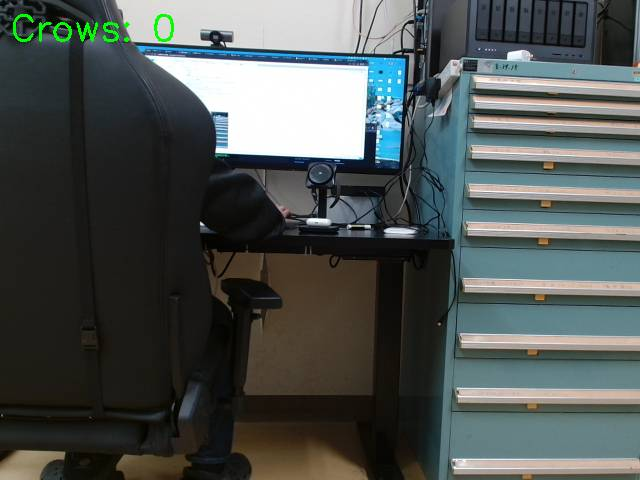

stop
released


In [ ]:
from ultralytics import YOLO
import cv2
from IPython.display import display, Image, clear_output

model = YOLO("runs/detect/crow_yolov8/weights/best.pt")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("カメラが開けませんでした。/dev/video0 を確認してください。")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

frame_i = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # 推論を軽く
        results = model(frame, imgsz=320, conf=0.25, verbose=False)[0]

        # crow(=class 0) の検出数
        crow_count = int((results.boxes.cls == 0).sum()) if results.boxes is not None else 0

        # 描画（重いのでNフレームに1回だけ）
        if frame_i % 5 == 0:
            annotated = results.plot()  # 重い
            cv2.putText(annotated, f"Crows: {crow_count}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

            ok, jpg = cv2.imencode(".jpg", annotated, [int(cv2.IMWRITE_JPEG_QUALITY), 70])
            if ok:
                clear_output(wait=True)
                display(Image(data=jpg.tobytes()))

        frame_i += 1

except KeyboardInterrupt:
    print("stop")

finally:
    cap.release()
    print("released")